use lagged_choice_non_zero_1-6 => exclude brand lag non zero (IRA did it this way)

In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

import optuna
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

from venn_abers import VennAbersCalibrator

In [129]:
# Read data

data = pd.read_excel("/Users/irynamatsiuk/Downloads/data_purchase_wide_Dominik.xlsx")

# Remove specified columns
columns_to_remove = [
                    "non_zero_brandlag", "NoIncome", "weekslast",
                    "trips", "lagged_choice_1", "lagged_choice_2",
                    "lagged_choice_3", "lagged_choice_4", "lagged_choice_5",
                    "lagged_choice_6", "brandlag", 'id', 'sumdollars', 'sumvol', 
                    'sumunits', 'store.id'
]
data = data.drop(columns=columns_to_remove)

# Adjust week numbers
data['week'] = data['week'] - 614  # gets weeks from 0 onwards, 614 min value
# Sorting weeks to do the 80/20 split
sorted_weeks = sorted(data['week'].unique())
train_ratio = 0.8
timing_train = int(train_ratio * len(sorted_weeks))
train_weeks = sorted_weeks[:timing_train]
test_weeks = sorted_weeks[timing_train:]

# Split data into training, calibration, and testing sets
train_data = data.loc[data['week'].isin(train_weeks)]
test_data = data.loc[data['week'].isin(test_weeks)]

x_train_venn = train_data.drop(columns=['brandbought'])
y_train_venn = train_data['brandbought']


# Further split the training data into training and calibration sets
x_train_full, x_calib, y_train_full, y_calib = train_test_split(train_data.drop(columns=['brandbought']),
                                                                train_data['brandbought'],
                                                                test_size=0.25, #20% of total set is calibration set as 0.8*0.25
                                                                random_state=123)

x_test, y_test = test_data.drop(columns=['brandbought']), test_data['brandbought']

Random Forest

In [130]:
# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create the model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=123
    )

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy_score(y_test, y_pred)


# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=123
)
model.fit(x_train_full, y_train_full)

[I 2024-06-17 00:44:30,977] A new study created in memory with name: no-name-e093c396-2562-4e5e-9154-5f4182d792c8
[I 2024-06-17 00:44:31,479] Trial 0 finished with value: 0.5214723926380368 and parameters: {'n_estimators': 164, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.5214723926380368.
[I 2024-06-17 00:44:31,651] Trial 1 finished with value: 0.5184049079754601 and parameters: {'n_estimators': 51, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5214723926380368.
[I 2024-06-17 00:44:31,955] Trial 2 finished with value: 0.5214723926380368 and parameters: {'n_estimators': 95, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.5214723926380368.
[I 2024-06-17 00:44:32,097] Trial 3 finished with value: 0.5173824130879345 and parameters: {'n_estimators': 51, 'max_depth': 27, 'min_sample

Best hyperparameters:  {'n_estimators': 176, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'entropy'}
Best accuracy:  0.5337423312883436


RandomForestClassifier(criterion='entropy', max_depth=27, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=176, random_state=123)

feature importance for random forest (can be added to other models as well)

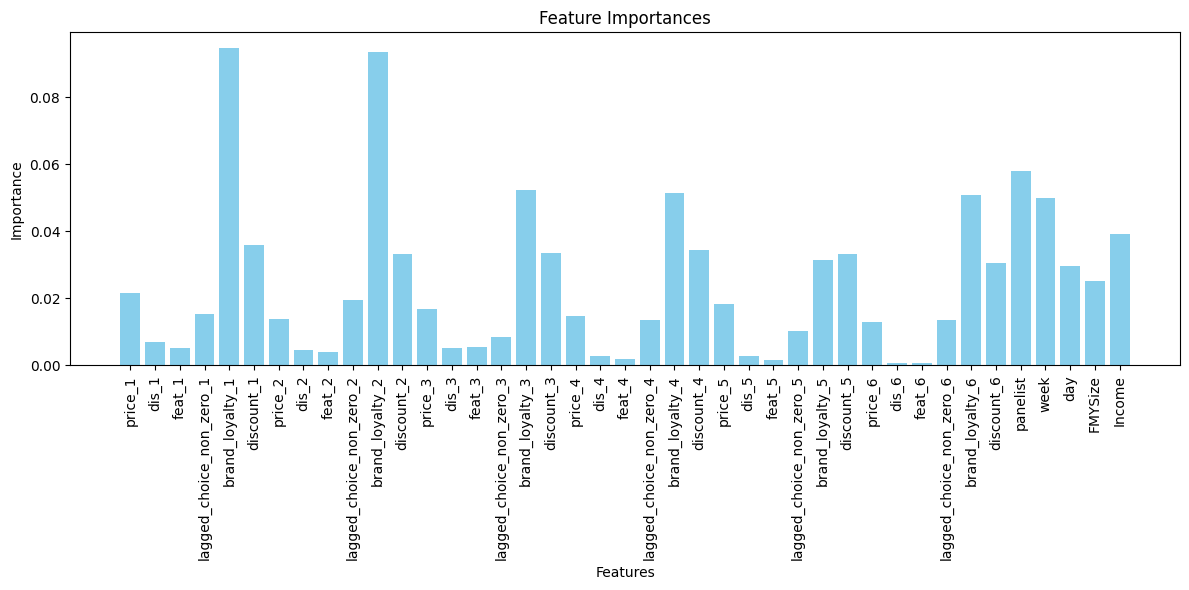

In [131]:
feature_importances = model.feature_importances_   
feature_names = x_train_full.columns

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  
plt.tight_layout()       
plt.show()

In [180]:
X = data.copy()
y = X["brandbought"]
X.head(5)

price_1  dis_1  feat_1  lagged_choice_non_zero_1  brand_loyalty_1  \
0     0.25      1       1                         0              0.0   
1     0.25      0       0                         1              1.0   
2     0.26      0       0                         1              1.0   
3     0.19      1       1                         0              0.0   
4     0.22      1       0                         1              1.0   

   discount_1  price_2  dis_2  feat_2  lagged_choice_non_zero_2  ...  feat_6  \
0    0.045328     0.15      0       0                         0  ...       0   
1   -0.014885     0.14      0       0                         0  ...       0   
2   -0.024885     0.14      1       1                         0  ...       0   
3   -0.016474     0.16      0       0                         0  ...       0   
4   -0.061206     0.11      1       1                         0  ...       0   

   lagged_choice_non_zero_6  brand_loyalty_6  discount_6  panelist  week  day  \
0                         0              0.0   -0.005511  14100842    85    6   
1                         0              0.0   -0.005511  14100842    87    1   
2                         0              0.0   -0.005511  14100842    88    4   
3                         0              0.0   -0.010134  14101667     2    2   
4                         0              0.0   -0.010134  14101667     4    5   

   brandbought  FMYSize  Income  
0            1        1       4  
1            1        1       4  
2            1        1       4  
3            1        2       7  
4            1        2       7  

[5 rows x 42 columns]

In [178]:

lagged_choice = []
brand_loyalty = []
discount = []
price = []
for i in np.arange(1,7):
    lagged_choice.append(f"lagged_choice_non_zero_{i}")
    brand_loyalty.append(f"brand_loyalty_{i}")
    discount.append(f"discount_{i}")
    price.append(f"price_{i}")


In [169]:
indices_lagged_choice = [X.columns.get_loc(col) for col in lagged_choice]
indices_brand_loyalty = [X.columns.get_loc(col) for col in brand_loyalty]
indices_discount = [X.columns.get_loc(col) for col in discount]
indices_price = [X.columns.get_loc(col) for col in price]



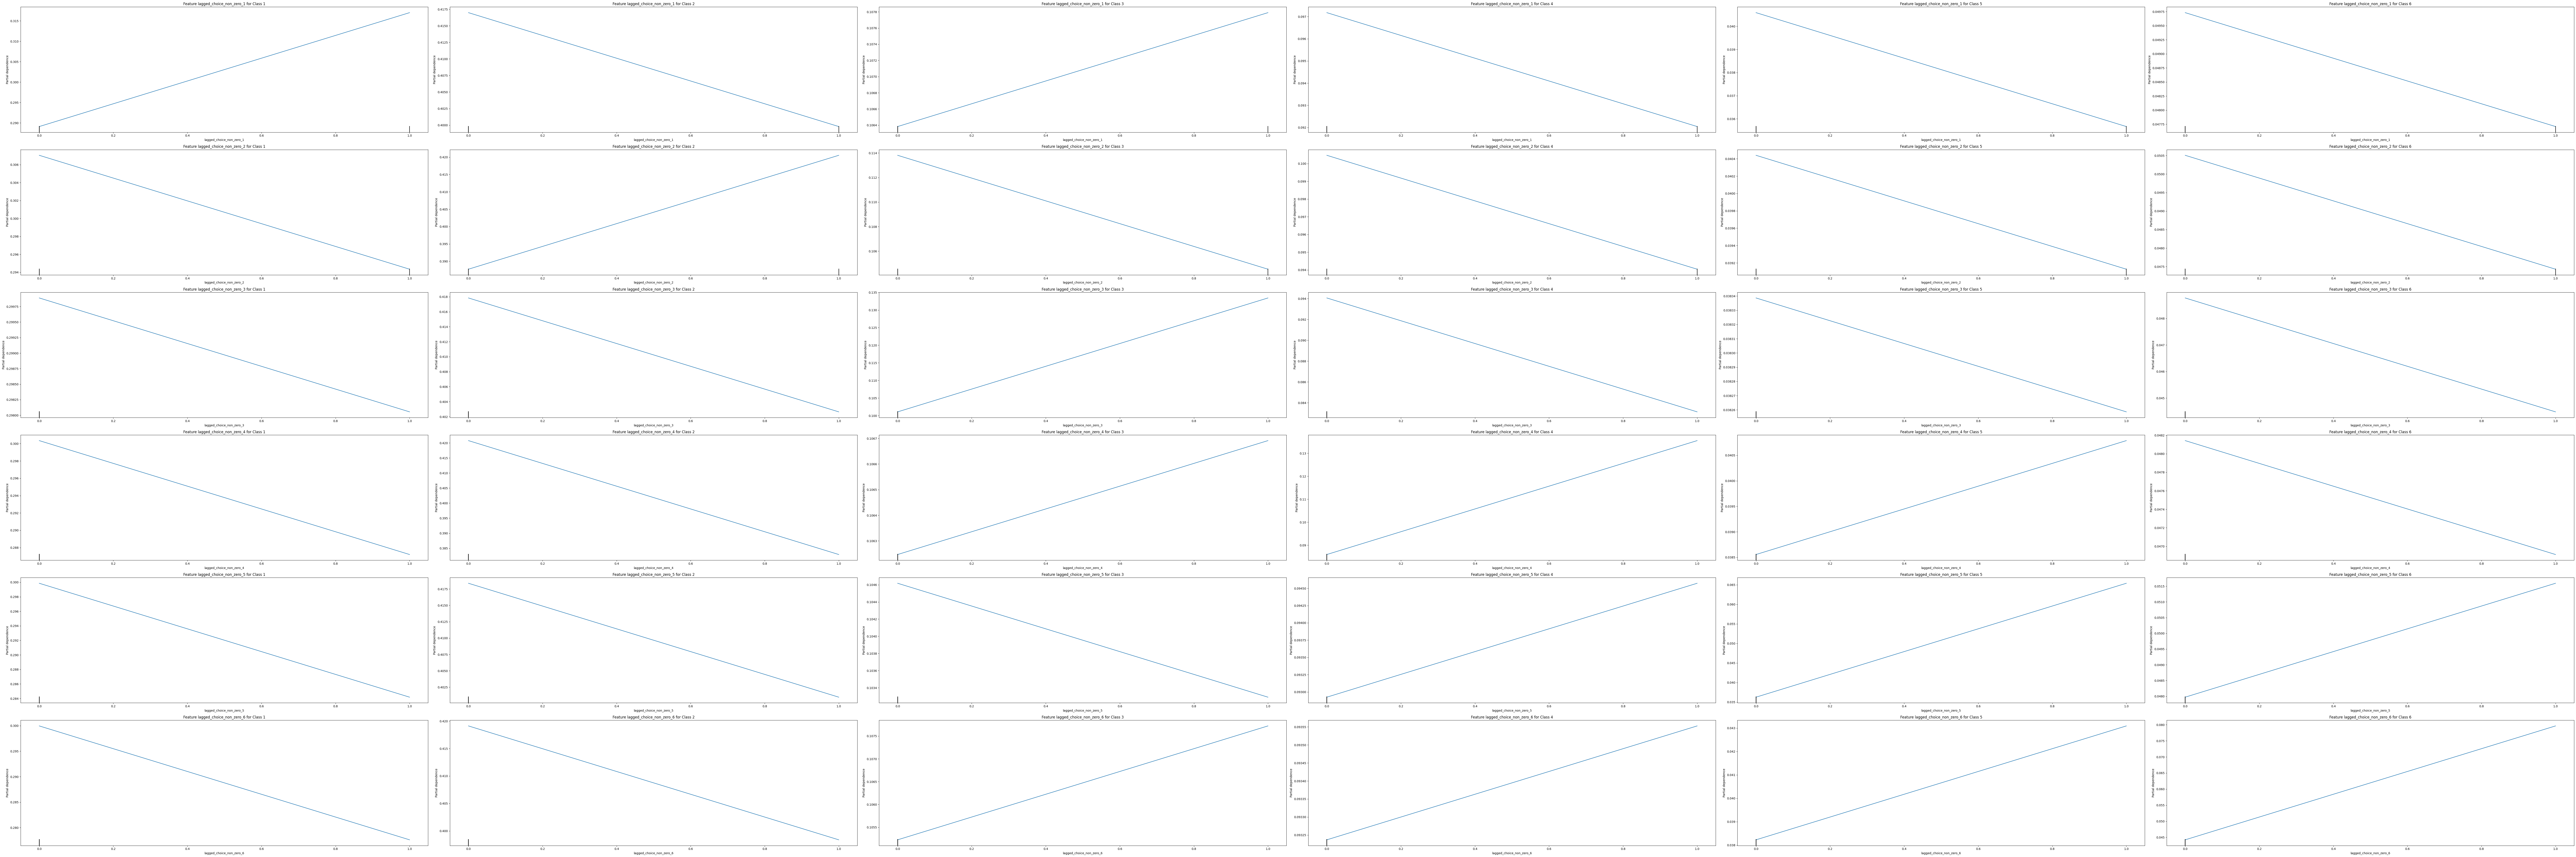

In [124]:
clf = RandomForestClassifier()
clf.fit(X, y)

features = indices_lagged_choice

fig, axes = plt.subplots(len(features), len(model.classes_), figsize=(40, 40))



for i, feature in enumerate(features):
    for j, class_label in enumerate(clf.classes_):
        ax = axes[i, j]  
        pdp = PartialDependenceDisplay.from_estimator(
            clf, X, [feature], target=class_label, ax=ax, grid_resolution=50
        )
        ax.set_title(f'Feature {X.columns[feature]} for Class {class_label}')

plt.tight_layout()
plt.show()

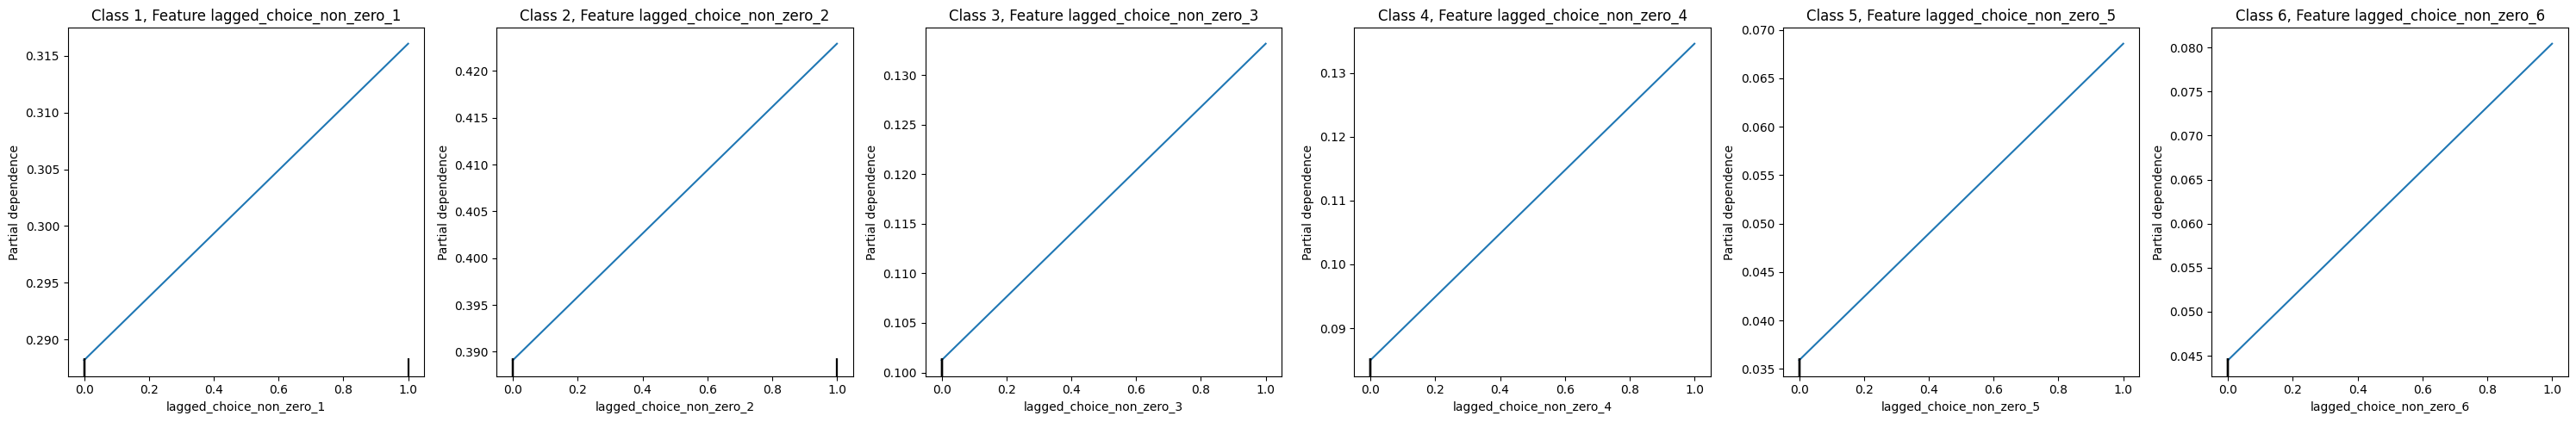

In [170]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

# Fit the RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)

features = indices_lagged_choice
n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

# Loop through each feature and plot the PDP for the matching class
for i, feature_index in enumerate(features):
    ax = axes[i]
    pdp = PartialDependenceDisplay.from_estimator(
        clf, X, [feature_index], target=clf.classes_[i], ax=ax, grid_resolution=50
    )
    ax.set_title(f'Class {clf.classes_[i]}, Feature {X.columns[feature_index]}')

plt.tight_layout()
plt.show()


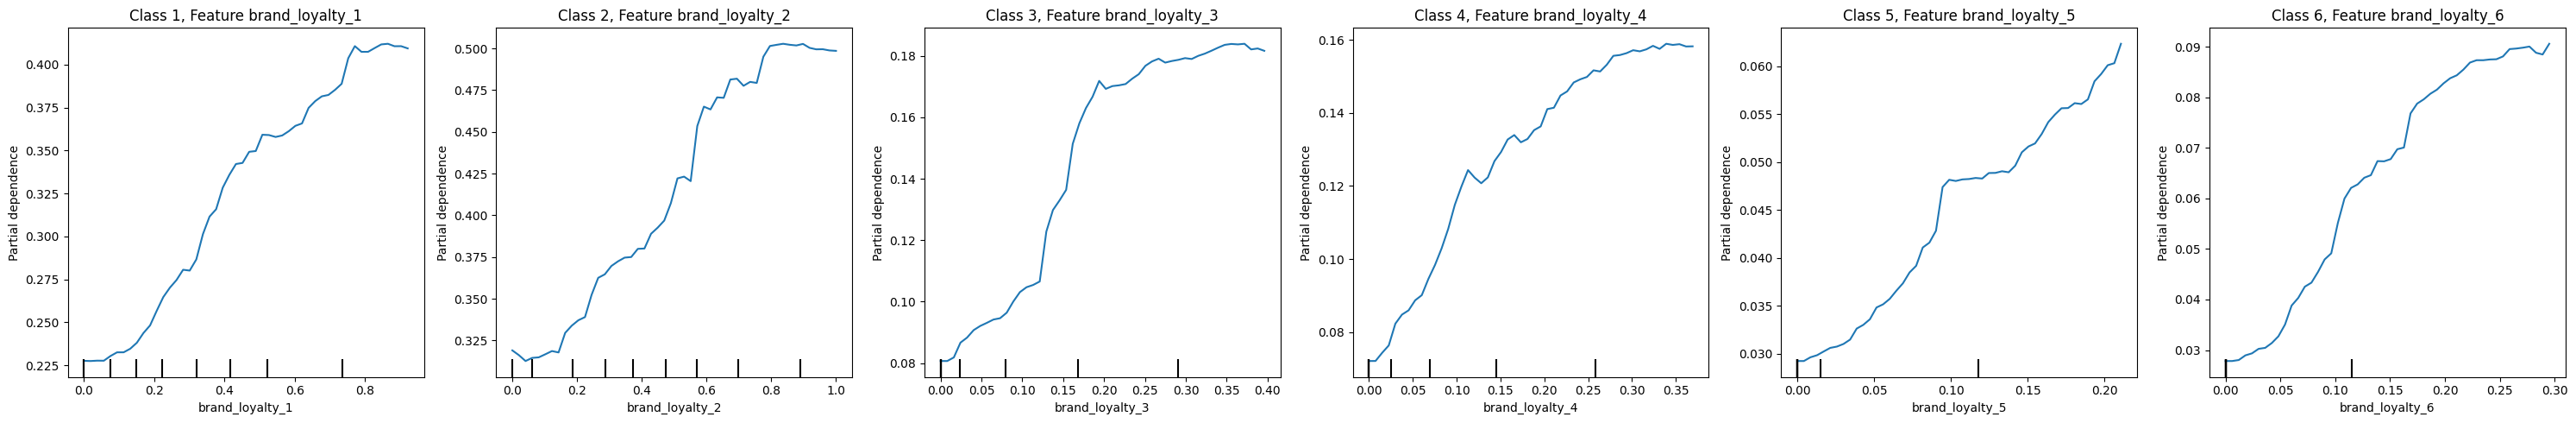

In [162]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

# Fit the RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)

features = indices_brand_loyalty
n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

for i, feature_index in enumerate(features):
    ax = axes[i]
    pdp = PartialDependenceDisplay.from_estimator(
        clf, X, [feature_index], target=clf.classes_[i], ax=ax, grid_resolution=50
    )
    ax.set_title(f'Class {clf.classes_[i]}, Feature {X.columns[feature_index]}')

plt.tight_layout()
plt.show()


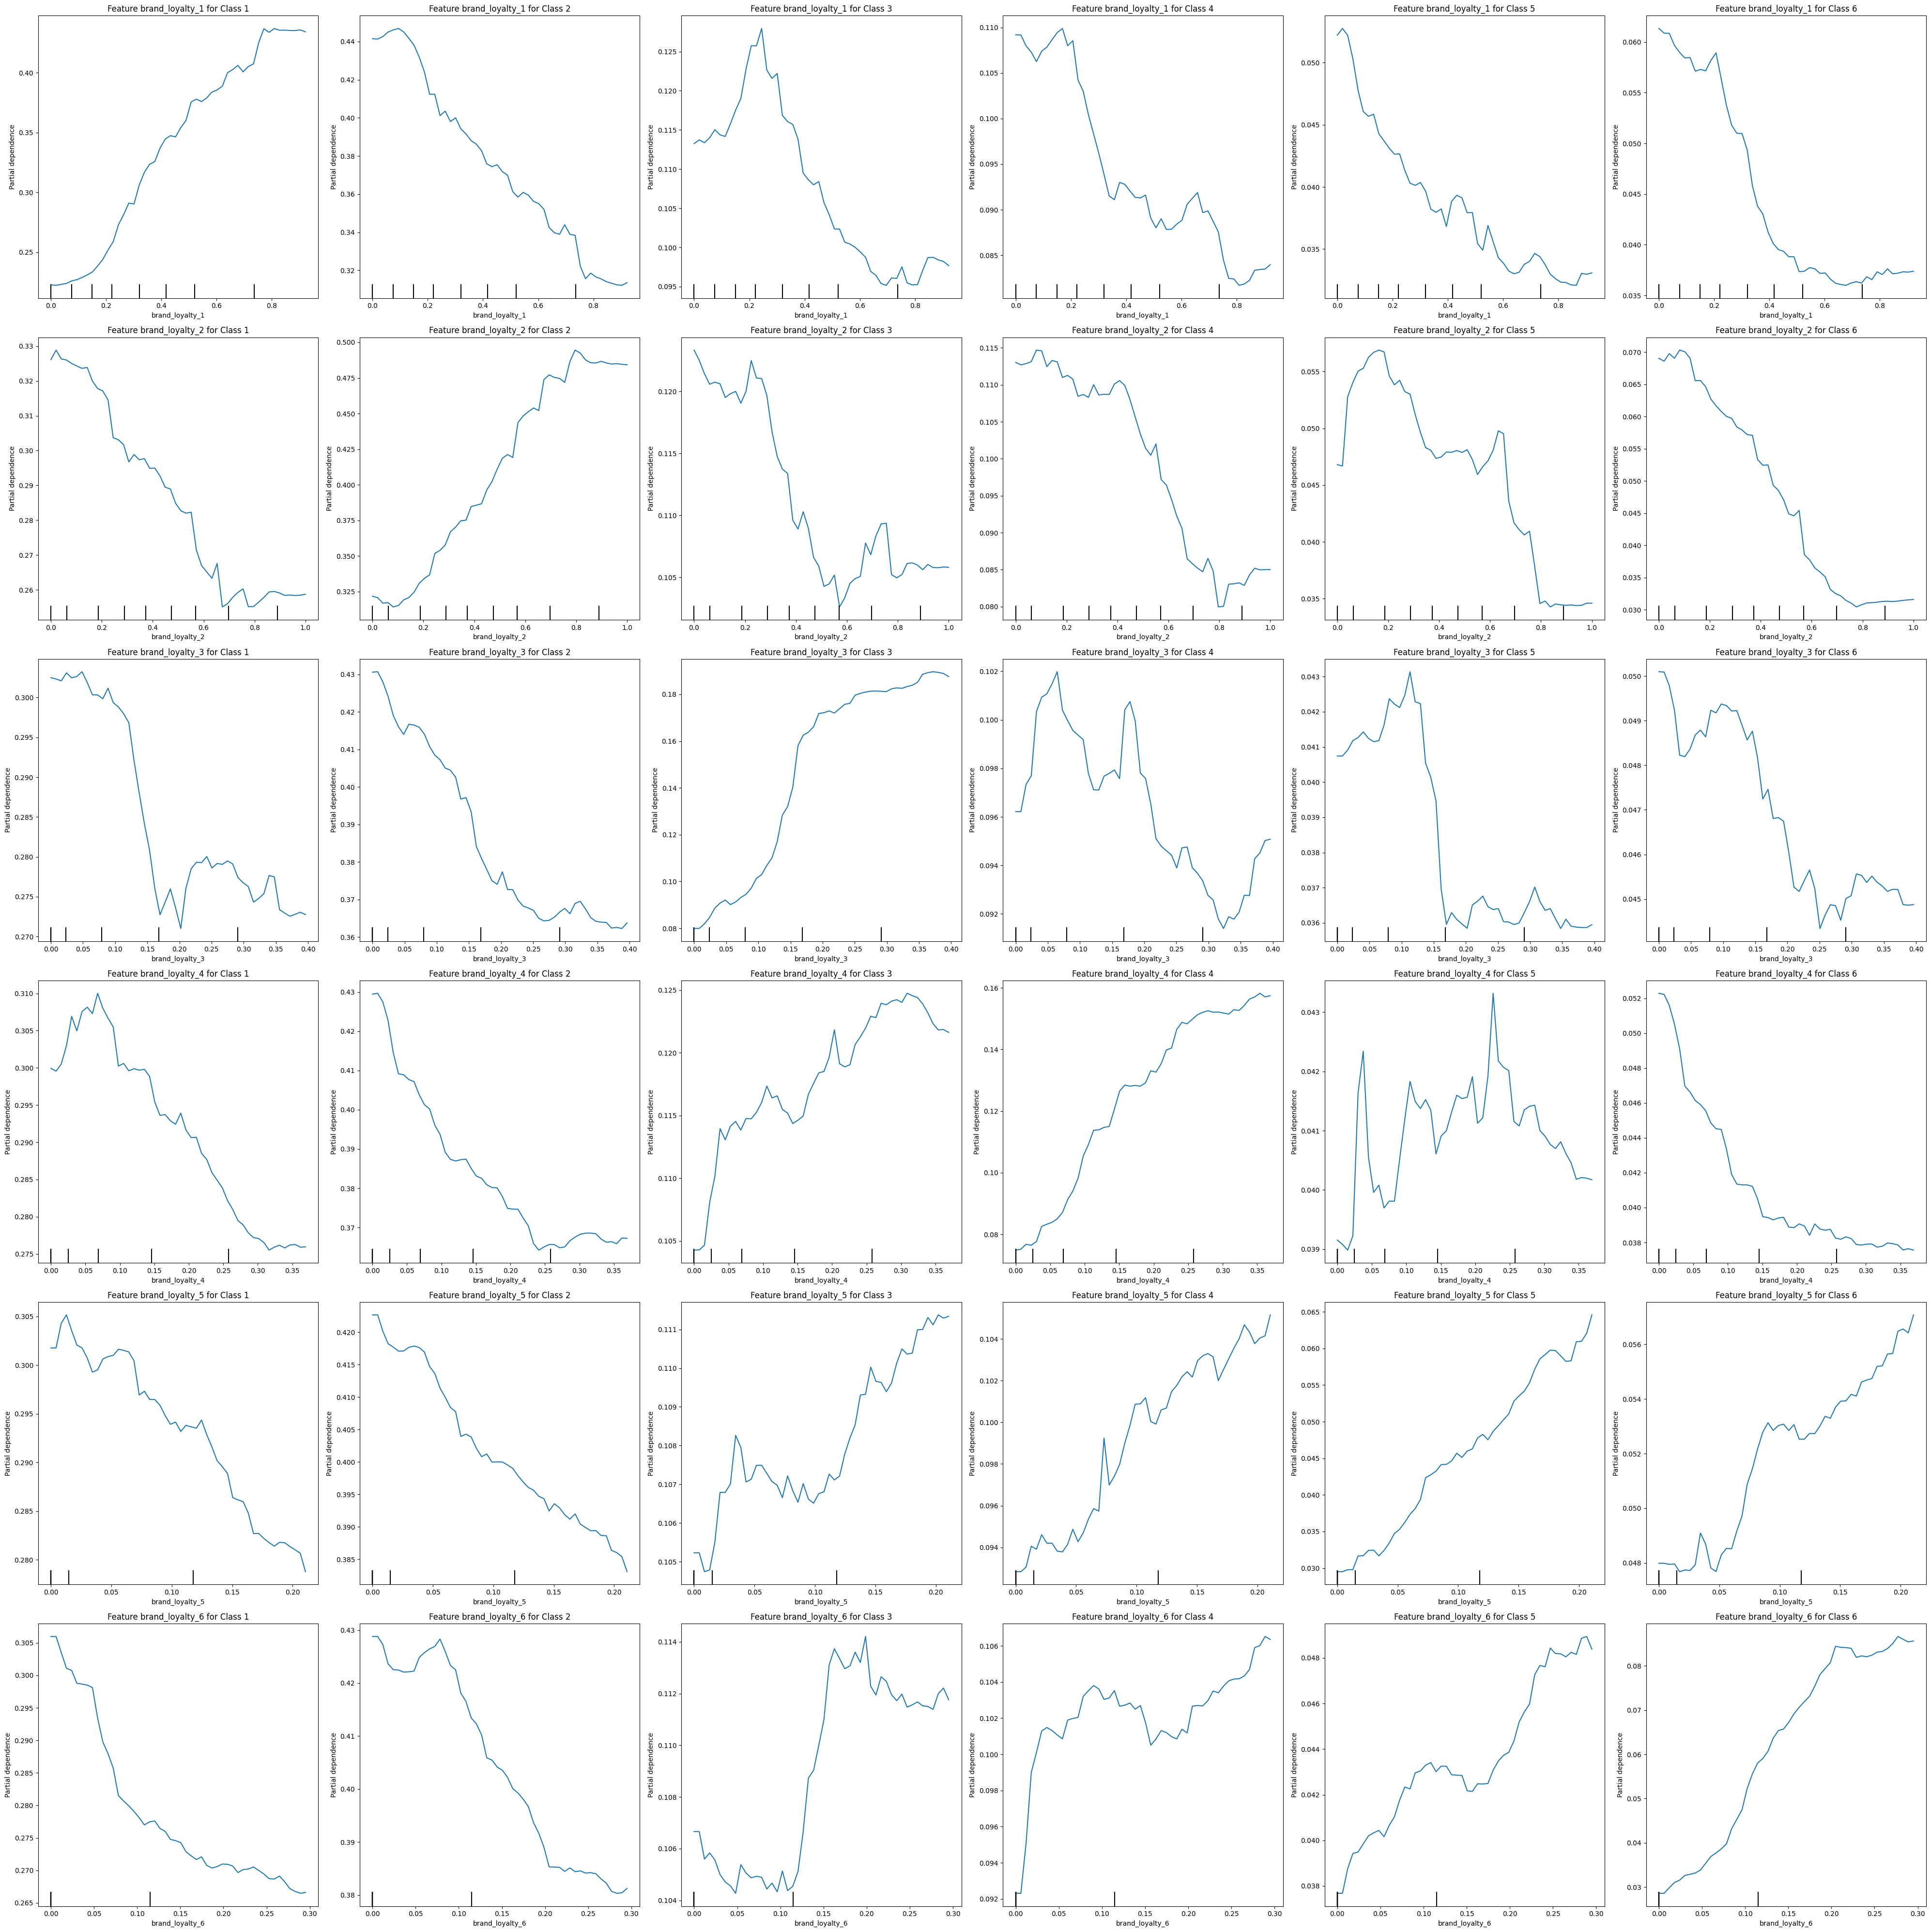

In [126]:
features = indices_brand_loyalty

fig, axes = plt.subplots(len(features), len(model.classes_), figsize=(40, 40))



for i, feature in enumerate(features):
    for j, class_label in enumerate(clf.classes_):
        ax = axes[i, j]  
        pdp = PartialDependenceDisplay.from_estimator(
            clf, X, [feature], target=class_label, ax=ax, grid_resolution=50
        )
        ax.set_title(f'Feature {X.columns[feature]} for Class {class_label}')

plt.tight_layout()
plt.show()

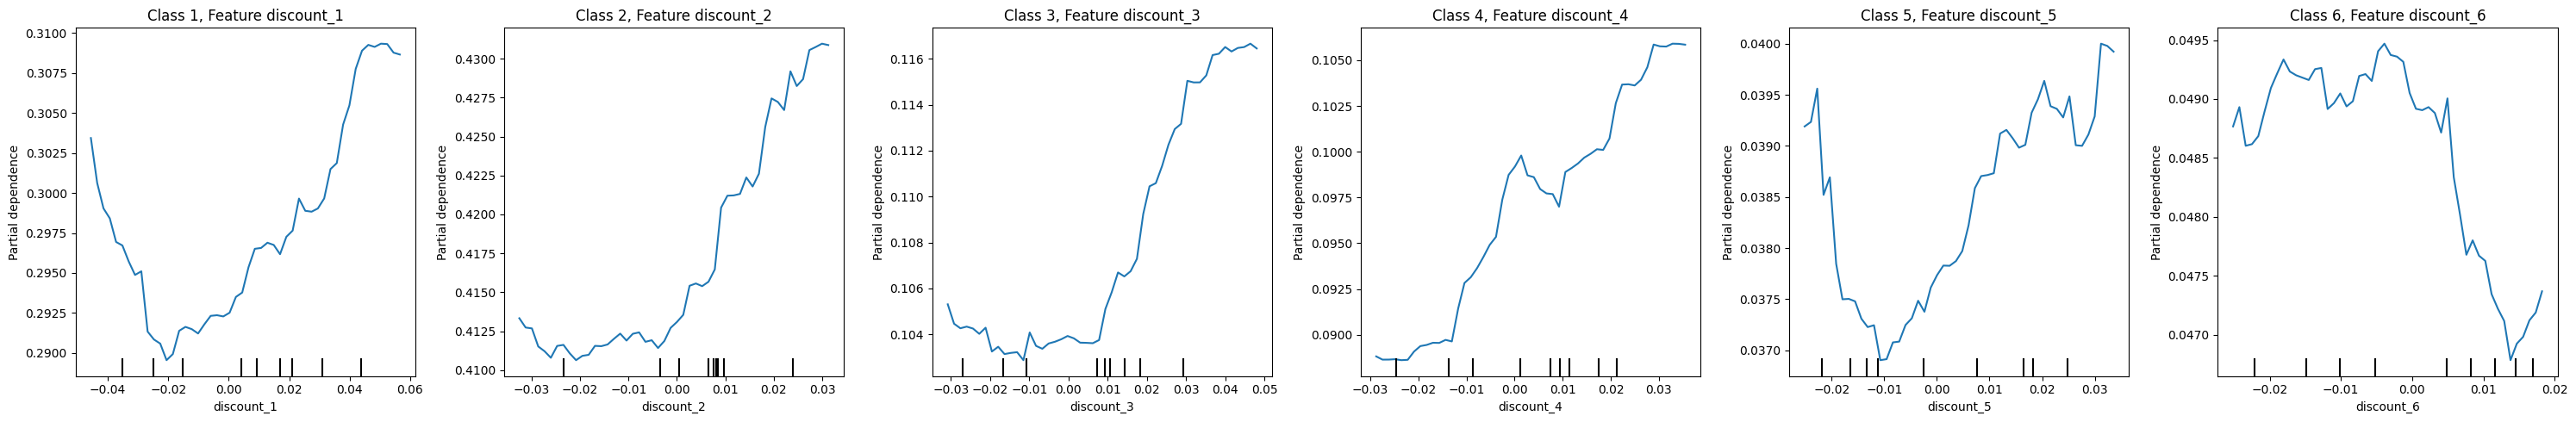

In [173]:

features = indices_discount
n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

for i, feature_index in enumerate(features):
    ax = axes[i]
    pdp = PartialDependenceDisplay.from_estimator(
        clf, X, [feature_index], target=clf.classes_[i], ax=ax, grid_resolution=50
    )
    ax.set_title(f'Class {clf.classes_[i]}, Feature {X.columns[feature_index]}')

plt.tight_layout()
plt.show()


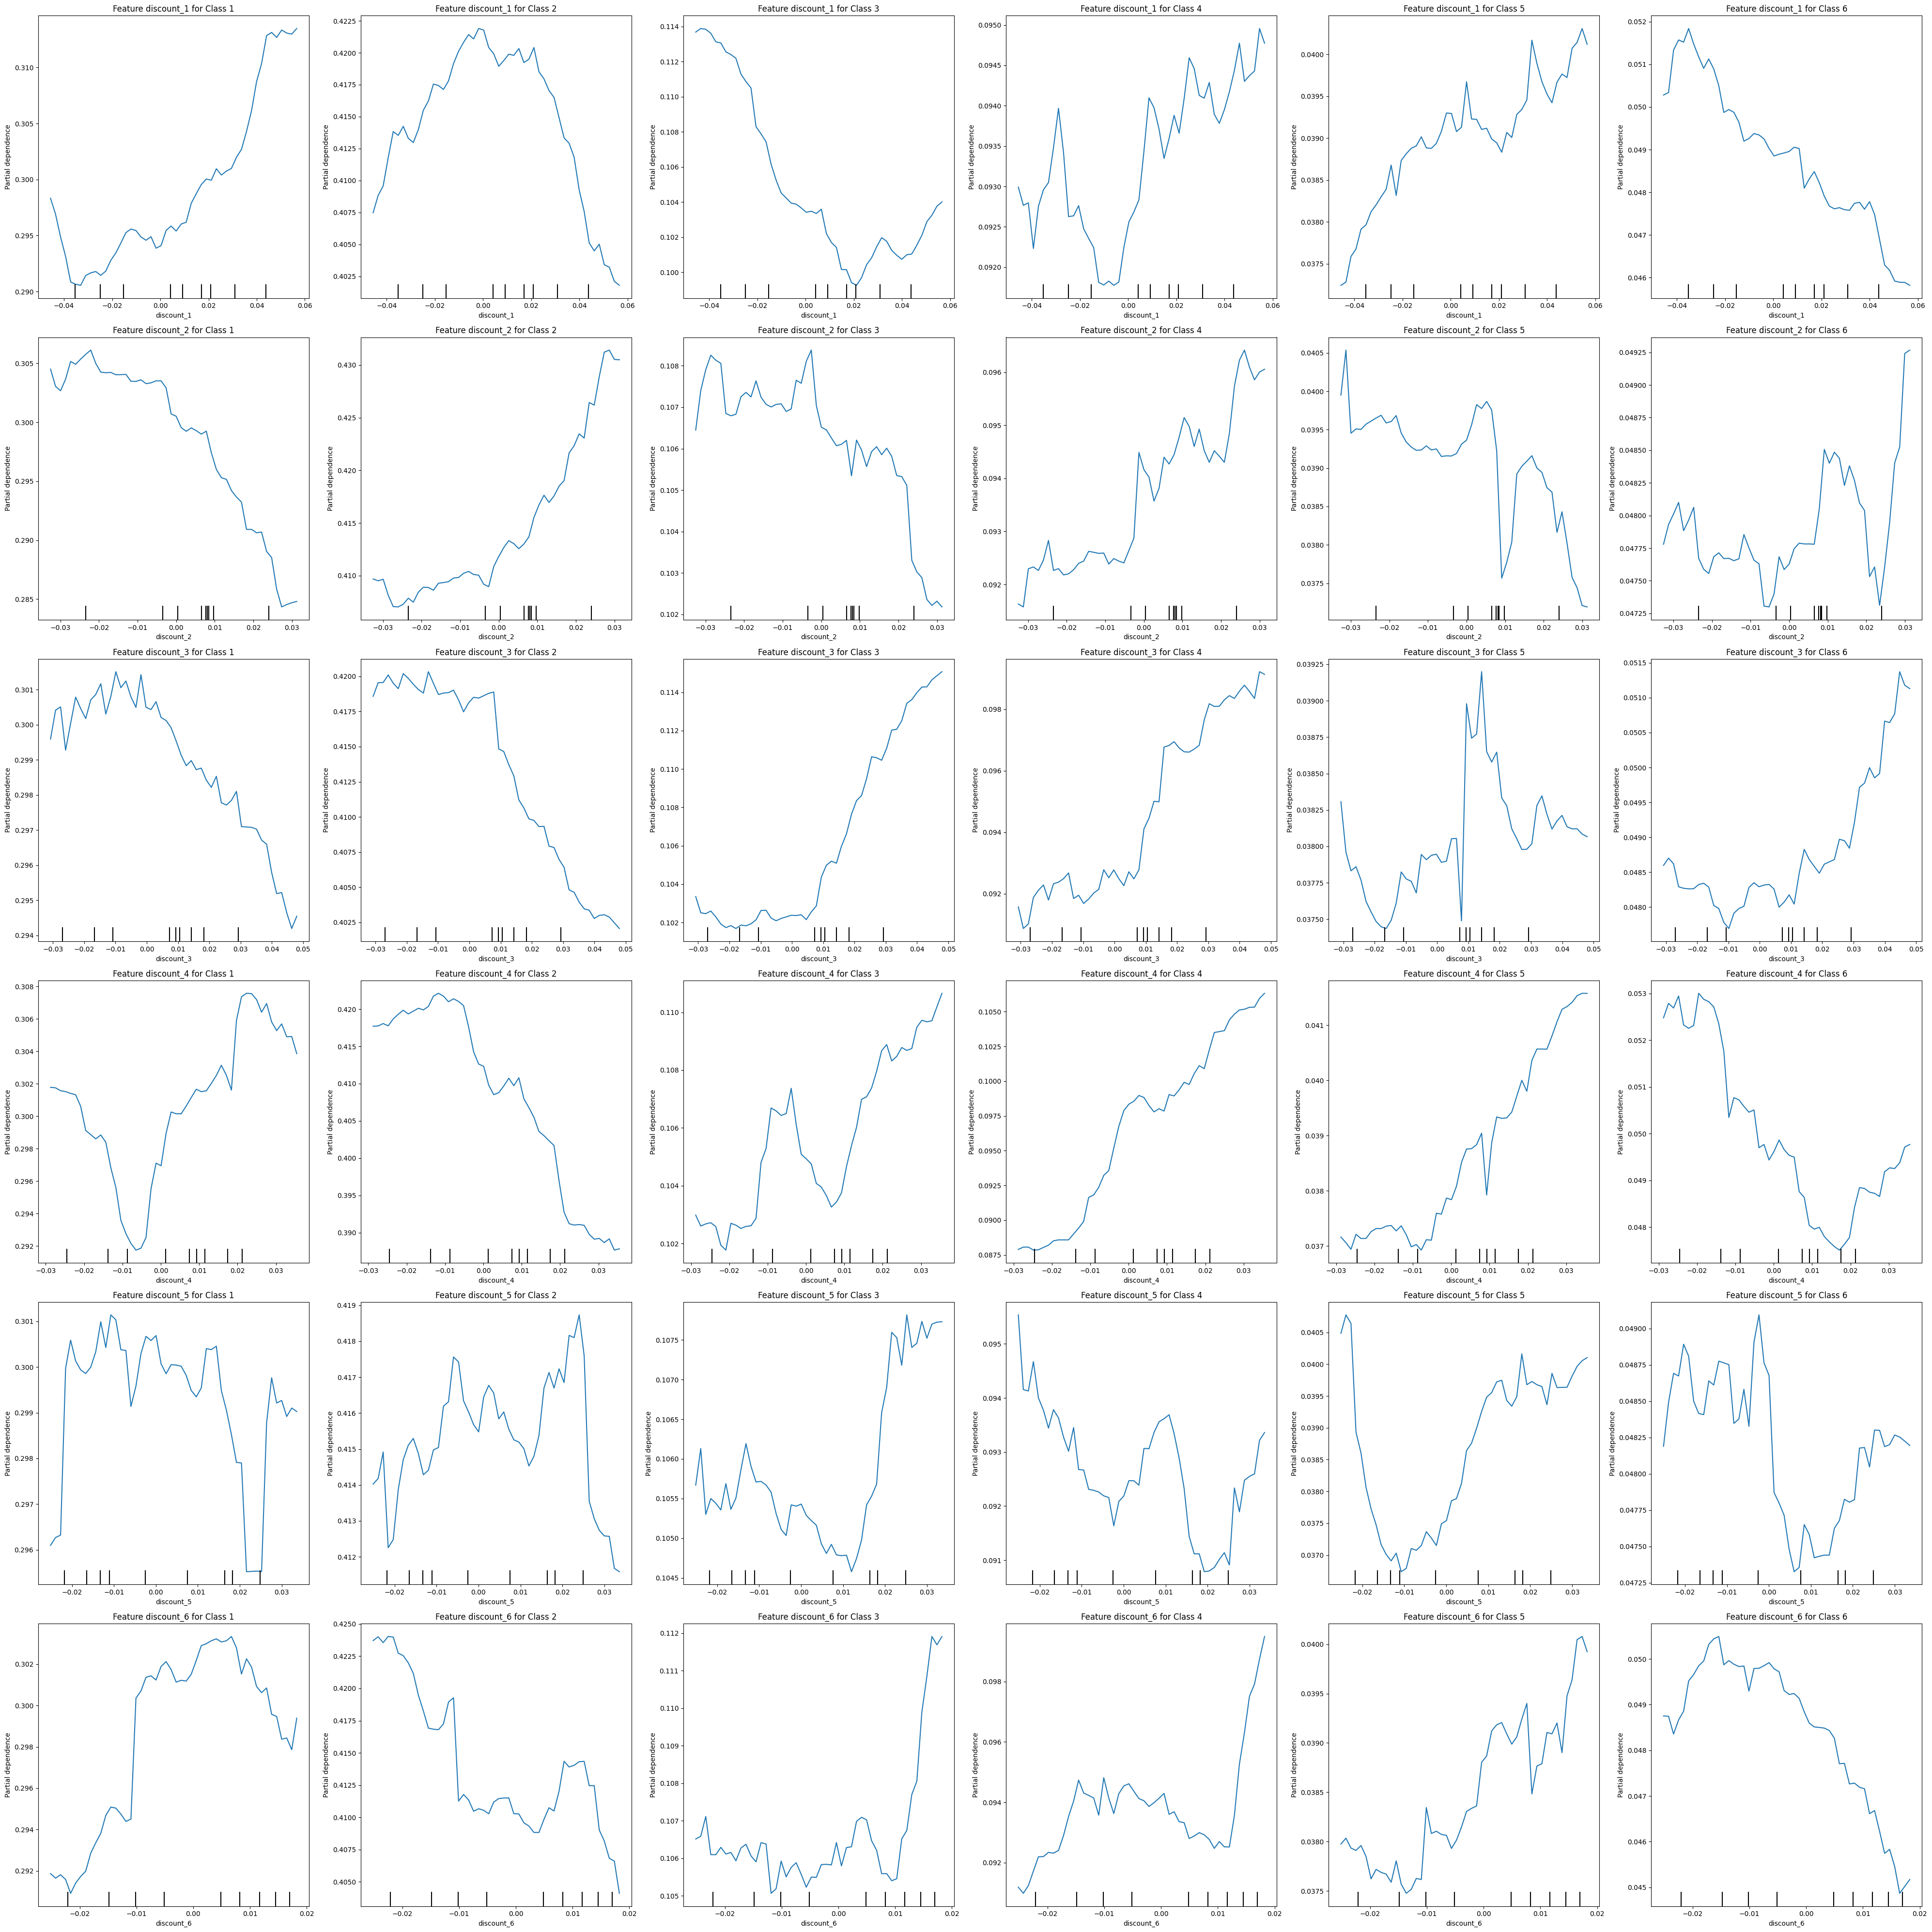

In [127]:
features = indices_discount

fig, axes = plt.subplots(len(features), len(model.classes_), figsize=(40, 40))



for i, feature in enumerate(features):
    for j, class_label in enumerate(clf.classes_):
        ax = axes[i, j]  
        pdp = PartialDependenceDisplay.from_estimator(
            clf, X, [feature], target=class_label, ax=ax, grid_resolution=50
        )
        ax.set_title(f'Feature {X.columns[feature]} for Class {class_label}')

plt.tight_layout()
plt.show()

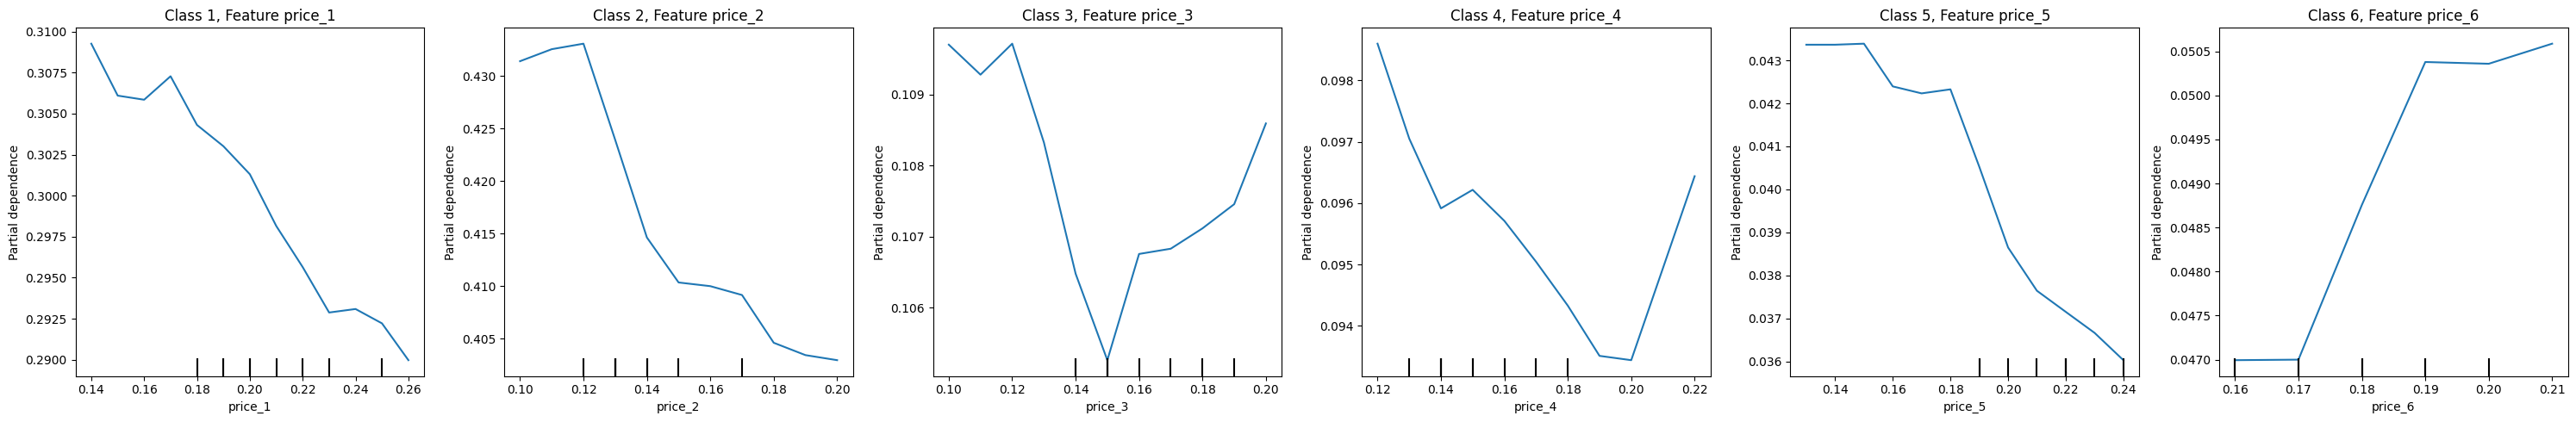

In [175]:
features = indices_price

n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

for i, feature_index in enumerate(features):
    ax = axes[i]
    pdp = PartialDependenceDisplay.from_estimator(
        clf, X, [feature_index], target=clf.classes_[i], ax=ax, grid_resolution=50
    )
    ax.set_title(f'Class {clf.classes_[i]}, Feature {X.columns[feature_index]}')

plt.tight_layout()
plt.show()



In [135]:
X.columns.get_loc("Income")

40

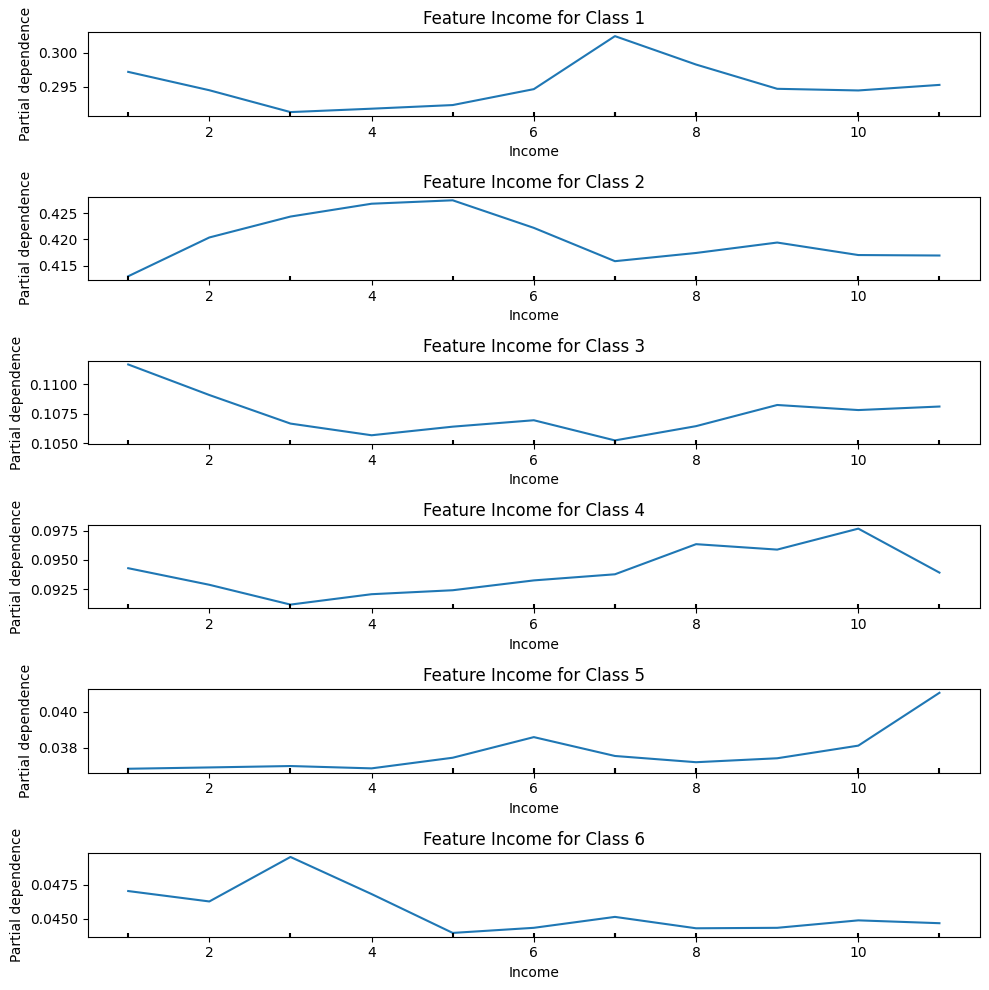

In [148]:
features = [40]
fig, axes = plt.subplots(len(model.classes_), 1, figsize=(10, 10))



for i, feature in enumerate(features):
    for j, class_label in enumerate(clf.classes_):
        ax = axes[j]  
        pdp = PartialDependenceDisplay.from_estimator(
            clf, X, [feature], target=class_label, ax=ax, grid_resolution=50
        )
        ax.set_title(f'Feature {X.columns[feature]} for Class {class_label}')

plt.tight_layout()

Calibration Random Forest with isotonic regression and venn predictor

In [7]:
# Make predictions with the original model
y_pred_original = model.predict(x_test)
y_pred_proba_original = model.predict_proba(x_test)

# Evaluate the original model
print("Original Model Results")
print("F1-score: ", f1_score(y_test, y_pred_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_original))

# Calculate the Brier score for each class and average them
brier_scores_original = []
for i in range(y_pred_proba_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_original[:, i])
    brier_scores_original.append(brier_score)

average_brier_score_original = sum(brier_scores_original) / len(brier_scores_original)
print("Average Brier Score: ", average_brier_score_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_original)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the model using isotonic regression
calibrated = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
calibrated.fit(x_calib, y_calib)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Isotonic Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)


# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Venn Predictor Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

Original Model Results
F1-score:  0.5184956996949628
ROC-AUC:  0.8054748976911862
Accuracy:  0.5439672801635992
Average Brier Score:  0.16347655396092023
Confusion Matrix:
[[180 117   9   6   1   4]
 [ 75 268   8  11   3   8]
 [ 43  57  18   3   2   1]
 [ 26  38   5  18   1   2]
 [  3   8   1   1  12   0]
 [  2  10   0   1   0  36]]
Calibrated Isotonic Model Results
F1-score:  0.5041235854593074
ROC-AUC:  0.8054534811594559
Accuracy:  0.5306748466257669
Average Brier Score:  0.16667239819307153
Confusion Matrix:
[[157 141  10   4   1   4]
 [ 67 279   9   7   3   8]
 [ 40  59  22   2   0   1]
 [ 24  44   5  15   0   2]
 [  3   8   1   3  10   0]
 [  2  10   0   1   0  36]]


XGBoost

In [ ]:
#since can calibrate only when values start with 0
y_train_full = y_train_full - 1
y_test  = y_test - 1
y_calib = y_calib -1 

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**param, objective='multi:softprob', random_state=123)

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
xgb_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    objective='multi:softprob',
    random_state=123
)
xgb_model.fit(x_train_full, y_train_full)

# Make predictions with the original XGBoost model
y_pred_xgb_original = xgb_model.predict(x_test)
y_pred_proba_xgb_original = xgb_model.predict_proba(x_test)

# Evaluate the original XGBoost model
print("Original XGBoost Model Results")
print("F1-score: ", f1_score(y_test, y_pred_xgb_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_xgb_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb_original))

# Calculate the Brier score for each class and average them
brier_scores_xgb_original = []
for i in range(y_pred_proba_xgb_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_xgb_original[:, i])
    brier_scores_xgb_original.append(brier_score)

average_brier_score_xgb_original = sum(brier_scores_xgb_original) / len(brier_scores_xgb_original)
print("Average Brier Score: ", average_brier_score_xgb_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_xgb_original)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the XGBoost model using the calibration set
calibrated_xgb = CalibratedClassifierCV(xgb_model, method="isotonic", cv="prefit")
calibrated_xgb.fit(x_calib, y_calib)

# Make predictions with the calibrated XGBoost model
y_pred_xgb_calib = calibrated_xgb.predict(x_test)
y_pred_proba_xgb_calib = calibrated_xgb.predict_proba(x_test)

# Evaluate the calibrated XGBoost model
print("Calibrated XGBoost Model Results with isotonic regression")
print("F1-score: ", f1_score(y_test, y_pred_xgb_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_xgb_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb_calib))

# Calculate the Brier score for each class and average them
brier_scores_xgb_calib = []
for i in range(y_pred_proba_xgb_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_xgb_calib[:, i])
    brier_scores_xgb_calib.append(brier_score)

average_brier_score_xgb_calib = sum(brier_scores_xgb_calib) / len(brier_scores_xgb_calib)
print("Average Brier Score: ", average_brier_score_xgb_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_xgb_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results with Venn Predictor")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

[I 2024-06-16 16:37:03,174] A new study created in memory with name: no-name-1c4ed849-d708-42b0-ae77-487c6990eb84
[I 2024-06-16 16:37:03,616] Trial 0 finished with value: 0.4754601226993865 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.11672604018436633, 'subsample': 0.8691677907299354, 'colsample_bytree': 0.9295332114227421, 'gamma': 1.8288252578927544, 'min_child_weight': 6}. Best is trial 0 with value: 0.4754601226993865.
[I 2024-06-16 16:37:03,924] Trial 1 finished with value: 0.4703476482617587 and parameters: {'n_estimators': 145, 'max_depth': 9, 'learning_rate': 0.28228636645567523, 'subsample': 0.8024397637246812, 'colsample_bytree': 0.5103319585032131, 'gamma': 3.7177631637008406, 'min_child_weight': 2}. Best is trial 0 with value: 0.4754601226993865.
[I 2024-06-16 16:37:04,353] Trial 2 finished with value: 0.4734151329243354 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.17750747461095773, 'subsample': 0.7611503127533397, '

Best hyperparameters:  {'n_estimators': 144, 'max_depth': 6, 'learning_rate': 0.0945116652576948, 'subsample': 0.8182105598305288, 'colsample_bytree': 0.8032466278356003, 'gamma': 0.6313466865763488, 'min_child_weight': 4}
Best accuracy:  0.4938650306748466
Original XGBoost Model Results
F1-score:  0.4748393564339562
ROC-AUC:  0.7478406450873729
Accuracy:  0.4938650306748466
Average Brier Score:  0.10681003469413393
Confusion Matrix:
[[179 114   8  11   1   4]
 [ 97 227  10  26   3  10]
 [ 39  52  20   7   3   3]
 [ 36  34   2  14   1   3]
 [  5   8   0   4   8   0]
 [  6   6   0   1   1  35]]
Calibrated XGBoost Model Results with isotonic regression
F1-score:  0.45508375687521346
ROC-AUC:  0.7439233862827476
Accuracy:  0.483640081799591
Average Brier Score:  0.10733563051193701
Confusion Matrix:
[[168 128   6  11   1   3]
 [101 241   8  16   2   5]
 [ 40  58  13   7   3   3]
 [ 37  40   2   8   1   2]
 [  4  10   0   3   8   0]
 [  6   6   0   1   1  35]]
Calibrated Model Results with

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0)
    }

    model = AdaBoostClassifier(**param, random_state=123)

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
ada_model = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=123
)
ada_model.fit(x_train_full, y_train_full)

# Make predictions with the original AdaBoost model
y_pred_ada_original = ada_model.predict(x_test)
y_pred_proba_ada_original = ada_model.predict_proba(x_test)

# Evaluate the original AdaBoost model
print("Original AdaBoost Model Results")
print("F1-score: ", f1_score(y_test, y_pred_ada_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_ada_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_original))

# Calculate the Brier score for each class and average them
brier_scores_ada_original = []
for i in range(y_pred_proba_ada_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_ada_original[:, i])
    brier_scores_ada_original.append(brier_score)

average_brier_score_ada_original = sum(brier_scores_ada_original) / len(brier_scores_ada_original)
print("Average Brier Score: ", average_brier_score_ada_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_ada_original)
print("Confusion Matrix:")
print(conf_matrix_rf)


# Calibrate the AdaBoost model using the calibration set
calibrated_ada = CalibratedClassifierCV(ada_model, method="isotonic", cv="prefit")
calibrated_ada.fit(x_calib, y_calib)

# Make predictions with the calibrated AdaBoost model
y_pred_ada_calib = calibrated_ada.predict(x_test)
y_pred_proba_ada_calib = calibrated_ada.predict_proba(x_test)

# Evaluate the calibrated AdaBoost model
print("Calibrated AdaBoost Model Results with Isotonic Regression")
print("F1-score: ", f1_score(y_test, y_pred_ada_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_ada_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_calib))

# Calculate the Brier score for each class and average them
brier_scores_ada_calib = []
for i in range(y_pred_proba_ada_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_ada_calib[:, i])
    brier_scores_ada_calib.append(brier_score)

average_brier_score_ada_calib = sum(brier_scores_ada_calib) / len(brier_scores_ada_calib)
print("Average Brier Score: ", average_brier_score_ada_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_ada_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results with Venn Predictor")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)


[I 2024-06-16 16:37:58,837] A new study created in memory with name: no-name-c1d28ea1-8bdc-4ed3-80c9-66c98728e3c4
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-06-16 16:37:59,467] Trial 0 finished with value: 0.40286298568507156 and parameters: {'n_estimators': 93, 'learning_rate': 0.4797349751912437}. Best is trial 0 with value: 0.40286298568507156.
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-06-16 16:38:00,380] Trial 1 finished with value: 0.3803680981595092 and parameters: {'n_estimators': 80, 'learning_rate': 0.1793960

Best hyperparameters:  {'n_estimators': 51, 'learning_rate': 0.5856281944381885}
Best accuracy:  0.4130879345603272
Original AdaBoost Model Results
F1-score:  0.3405444555274352
ROC-AUC:  0.6321698972551969
Accuracy:  0.4130879345603272
Average Brier Score:  0.13660018495632595
Confusion Matrix:
[[100 212   1   4   0   0]
 [ 77 294   1   1   0   0]
 [ 21  98   2   3   0   0]
 [ 20  69   0   1   0   0]
 [  5  20   0   0   0   0]
 [  7  35   0   0   0   7]]
Calibrated AdaBoost Model Results with Isotonic Regression
F1-score:  0.28946143886937303
ROC-AUC:  0.6448767392336435
Accuracy:  0.3987730061349693
Average Brier Score:  0.11833100862932512
Confusion Matrix:
[[ 36 273   1   2   0   5]
 [ 26 341   1   0   0   5]
 [ 13 105   3   1   0   2]
 [  8  80   0   1   0   1]
 [  8  16   0   0   0   1]
 [  2  38   0   0   0   9]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Calibrated Model Results with Venn Predictor
F1-score:  0.36843197242418146
ROC-AUC:  0.7241158034142888
Accuracy:  0.4458077709611452
Average Brier Score:  0.11016829384720733
Confusion Matrix:
[[180 137   0   0   0   0]
 [117 256   0   0   0   0]
 [ 56  68   0   0   0   0]
 [ 40  50   0   0   0   0]
 [ 11  14   0   0   0   0]
 [ 34  15   0   0   0   0]]


For Ira ICE and PDP plots but only for Ada Boost: change "features" row with which variables you want, right now it is looking at all train set columns

In [ ]:
x_train_full.columns

Index(['price_1', 'price_2', 'price_3', 'price_4', 'price_5', 'price_6',
       'dis_1', 'dis_2', 'dis_3', 'dis_4', 'dis_5', 'dis_6', 'feat_1',
       'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'store id', 'day',
       'week', 'panelist', 'FMYSize', 'Income', 'NoIncome'],
      dtype='object')

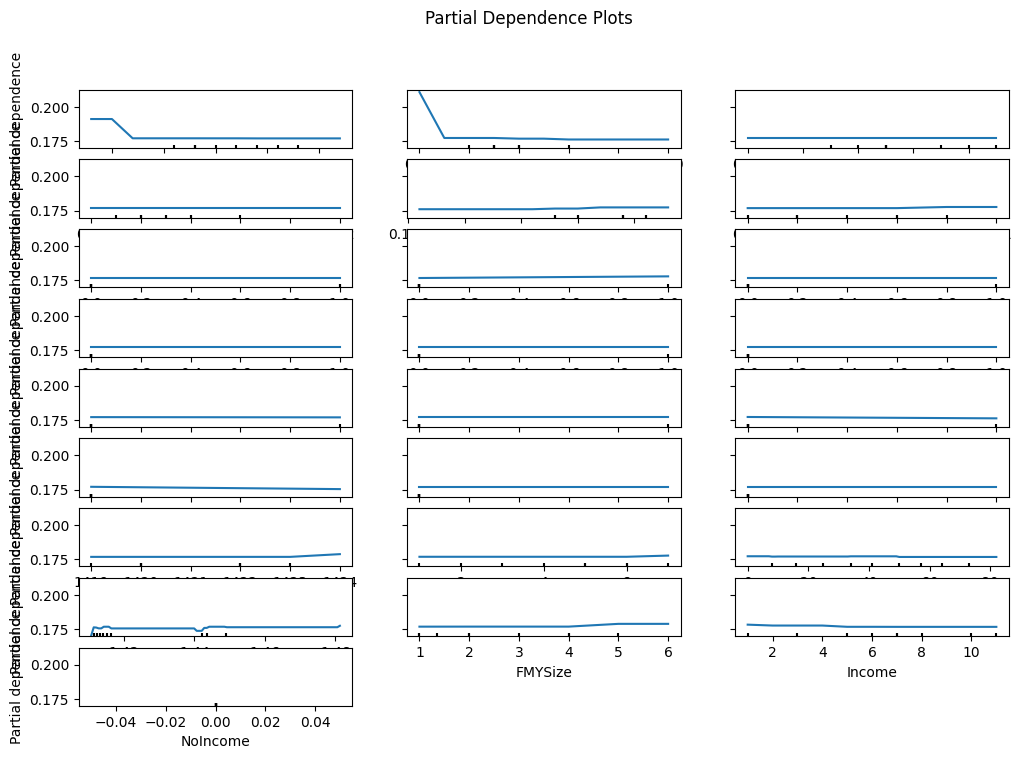

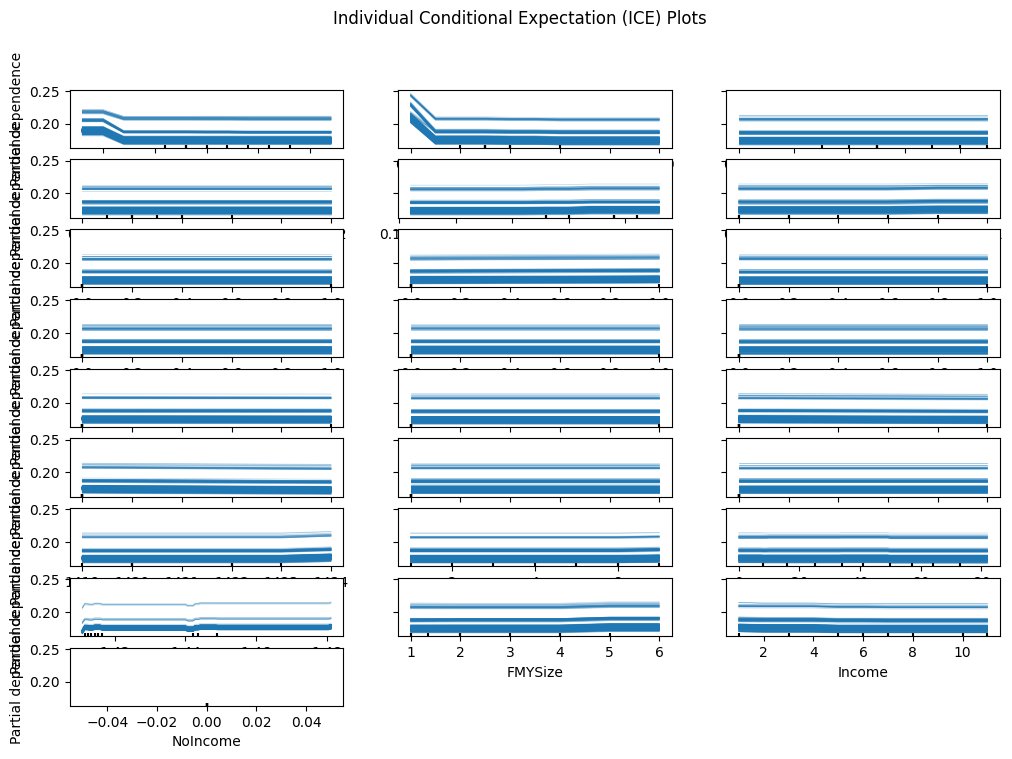

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming `ada_model` is your trained model and `x_train_full` is your training data
features = x_train_full.columns

# Define the target class for the partial dependence plots
target_class = 1 

# Plotting PDP
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(ada_model, x_train_full, features, ax=ax, target=target_class)
plt.suptitle('Partial Dependence Plots')
plt.show()

# Plotting ICE (Individual Conditional Expectation) plots
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(ada_model, x_train_full, features, kind='individual', ax=ax, target=target_class)
plt.suptitle('Individual Conditional Expectation (ICE) Plots')
plt.show()


5-fold cross validation with isotonic regression first, afterwards with venn predictor

Random forest + isotonic regression

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
        
rf = RandomForestClassifier()
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

In [ ]:
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
        
rf = RandomForestClassifier()
rf.fit(x_train_full, y_train_full)
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)
    
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)


Calibrated Model Results
F1-score:  0.3573676369131042
ROC-AUC:  0.6955596792812556
Accuracy:  0.4161554192229039
Average Brier Score:  0.11410401236619662


In [ ]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = RandomForestClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1

Confusion Matrix for Fold 1:
[[ 43 105   0   2   0   1]
 [ 42 169   0   3   2   1]
 [ 11  31   0   0   0   1]
 [ 15  17   0   8   1   1]
 [  5  11   0   1   4   0]
 [  6  15   0   0   0   7]]
Confusion Matrix for Fold 2:
[[ 78  78   0   1   0   0]
 [ 40 155   2   3   0   1]
 [ 12  31   6   2   0   0]
 [ 14  37   0   2   0   0]
 [  3  14   1   1   2   0]
 [  4  10   0   1   0   4]]
Confusion Matrix for Fold 3:
[[ 43 104   2   0   0   1]
 [ 40 176   1   1   0   3]
 [ 15  37   4   0   0   0]
 [  8  22   1   2   0   1]
 [  3  15   0   0   1   0]
 [  2  15   1   0   0   4]]
Confusion Matrix for Fold 4:
[[104  51   2   2   0   1]
 [ 56 132   3   0   1   1]
 [ 17  25   7   1   0   2]
 [ 11  33   1  13   0   0]
 [  7  12   1   2   1   0]
 [  0   9   0   1   1   5]]
Confusion Matrix for Fold 5:
[[ 83  60   3   5   0   1]
 [ 32 182   3   2   0   2]
 [ 12  34   6   3   0   0]
 [ 12  26   2   2   0   0]
 [  5   8   0   0   1   0]
 [  5   6   1   1   0   5]]


In [ ]:
calibrated.predict_proba(x_test)

array([[0.2819368 , 0.337172  , 0.10073008, 0.10531219, 0.02658438,
        0.14826456],
       [0.32003829, 0.33102348, 0.09738514, 0.12798987, 0.01518016,
        0.10838306],
       [0.33155792, 0.30183626, 0.12209361, 0.1348893 , 0.01633031,
        0.09329259],
       ...,
       [0.23392566, 0.43229023, 0.18169367, 0.1042642 , 0.03735043,
        0.01047581],
       [0.44135015, 0.31603157, 0.09252596, 0.08917281, 0.03722027,
        0.02369925],
       [0.23825768, 0.4136403 , 0.16485107, 0.08620727, 0.02057451,
        0.07646916]])

Random forest + venn predictor + 5-fold-cross-validation

In [ ]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.40531697341513295 ± 0.017893368387916043
F1 Score: 0.3383482311019202 ± 0.02996791904960444
ROC AUC: 0.6686814016411072 ± 0.016673125991717684
Brier Score Loss: 0.11706537533366065 ± 0.0013814401373936937
Confusion Matrix for fold 1:
[[110 204   0   1   1   1]
 [116 256   0   1   0   0]
 [ 39  85   0   0   0   0]
 [ 34  56   0   0   0   0]
 [ 11  14   0   0   0   0]
 [ 31  16   0   0   0   2]]
Confusion Matrix for fold 2:
[[128 182   1   3   2   1]
 [113 242   4  12   1   1]
 [ 27  87   3   7   0   0]
 [ 33  53   0   4   0   0]
 [ 12   9   0   4   0   0]
 [ 22  13   2   3   1   8]]
Confusion Matrix for fold 3:
[[ 43 267   2   1   2   2]
 [ 18 351   1   2   1   0]
 [ 10 109   2   1   2   0]
 [ 10  78   0   0   1   1]
 [  6  19   0   0   0   0]
 [  5  37   0   0   0   7]]
Confusion Matrix for fold 4:
[[144 156   3   7   6   1]
 [104 250   2  12   4   1]
 [ 40  68   4   4   7   1]
 [ 35  45   2   5   2   1]
 [  9   6   

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


XGBoost

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Ensure target labels are zero-based
y_train_zero_based = y_train_full - y_train_full.min()
y_test_zero_based = y_test - y_train_full.min()

def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf = XGBClassifier()
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_zero_based)

CalibratedClassifierCV(cv=<generator object time_dependent_k_fold_split at 0x000002F13941B790>,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=N...
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       method='isotonic')

In [ ]:
# Evaluate the model
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, brier_score_loss

y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test_zero_based, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test_zero_based, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test_zero_based, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = [brier_score_loss((y_test_zero_based == i).astype(int), y_pred_proba_calib[:, i]) for i in range(y_pred_proba_calib.shape[1])]
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

Calibrated Model Results
F1-score:  0.430795756796337
ROC-AUC:  0.7216805328268342
Accuracy:  0.4539877300613497
Average Brier Score:  0.10975143943699556


In [ ]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = XGBClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1

Confusion Matrix for Fold 1:
[[ 54  92   1   3   1   0]
 [ 29 179   0   9   0   0]
 [  6  34   1   2   0   0]
 [  8  24   0  10   0   0]
 [  4  14   0   1   2   0]
 [  3  18   0   0   0   7]]
Confusion Matrix for Fold 2:
[[ 77  70   2   6   2   0]
 [ 42 154   2   2   1   0]
 [ 13  30   6   1   1   0]
 [ 14  32   0   5   2   0]
 [  2   8   0   3   8   0]
 [  1   7   0   2   0   9]]
Confusion Matrix for Fold 3:
[[ 40 109   1   0   0   0]
 [ 23 193   1   4   0   0]
 [  7  39   8   1   1   0]
 [  6  24   0   2   1   1]
 [  2  13   0   0   4   0]
 [  3  13   1   0   1   4]]
Confusion Matrix for Fold 4:
[[ 93  53   5   8   1   0]
 [ 37 142   6   5   1   2]
 [ 11  27   7   6   1   0]
 [ 10  20   3  25   0   0]
 [  3  10   3   1   6   0]
 [  0   4   0   1   2   9]]
Confusion Matrix for Fold 5:
[[ 98  45   4   3   0   2]
 [ 35 177   3   3   1   2]
 [ 15  30   8   2   0   0]
 [  8  20   4  10   0   0]
 [  4  10   0   0   0   0]
 [  2   8   0   1   0   7]]


In [ ]:
calibrated.predict_proba(x_test)

array([[0.32378093, 0.32879751, 0.07341796, 0.20627995, 0.02018631,
        0.04753734],
       [0.57626212, 0.22506264, 0.05834896, 0.08346445, 0.00920315,
        0.04765868],
       [0.46009244, 0.26992182, 0.07809645, 0.12088211, 0.01812462,
        0.05288257],
       ...,
       [0.19229978, 0.48879309, 0.19783188, 0.06272913, 0.03070992,
        0.02763619],
       [0.57615541, 0.21907065, 0.08064092, 0.082831  , 0.02942703,
        0.011875  ],
       [0.19841855, 0.5001874 , 0.13927989, 0.0473634 , 0.02680019,
        0.08795058]])

venn predictor + XGBoost + 5-fold-cross validation

In [ ]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = XGBClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.4269938650306749 ± 0.016721465109823825
F1 Score: 0.3879839935315519 ± 0.03663383710071799
ROC AUC: 0.6927303455851985 ± 0.014520737110728715
Brier Score Loss: 0.11492801957262819 ± 0.0015427278604055801
Confusion Matrix for fold 1:
[[ 58 254   0   2   1   2]
 [ 54 316   0   1   0   2]
 [ 16 107   0   1   0   0]
 [ 16  70   0   4   0   0]
 [  5  19   0   0   1   0]
 [ 13  16   0   1   0  19]]
Confusion Matrix for fold 2:
[[174 126   2   7   5   3]
 [155 197   1  12   6   2]
 [ 39  73   3   4   4   1]
 [ 44  38   1   6   1   0]
 [ 12   9   0   2   2   0]
 [ 19   6   3   1   1  19]]
Confusion Matrix for fold 3:
[[ 98 184  15   7  10   3]
 [ 71 268  10  13   8   3]
 [ 25  73  19   1   5   1]
 [ 17  58   5   8   1   1]
 [  3  13   2   1   6   0]
 [  8  13   0   0   1  27]]
Confusion Matrix for fold 4:
[[138 127  14  29   6   3]
 [ 85 215  18  48   3   4]
 [ 39  51  17  12   4   1]
 [ 30  32   4  21   1   2]
 [  3   3   5

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


AdaBoost

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf = AdaBoostClassifier(algorithm='SAMME')
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)
p_test_calibrated = calibrated.predict_proba(x_test)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
rf = AdaBoostClassifier(algorithm='SAMME')
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf.fit(x_train_full, y_train_full)
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)
    
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

Calibrated Model Results
F1-score:  0.22986523865219086
ROC-AUC:  0.6479099609823886
Accuracy:  0.38548057259713703
Average Brier Score:  0.11801527817081293


In [ ]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = AdaBoostClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 1:
[[ 11 140   0   0   0   0]
 [  6 211   0   0   0   0]
 [  2  41   0   0   0   0]
 [  7  35   0   0   0   0]
 [  3  18   0   0   0   0]
 [  1  26   0   0   0   1]]
Confusion Matrix for Fold 2:
[[ 31 126   0   0   0   0]
 [ 19 182   0   0   0   0]
 [ 10  41   0   0   0   0]
 [  9  44   0   0   0   0]
 [  2  19   0   0   0   0]
 [  2  16   0   1   0   0]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 3:
[[  5 145   0   0   0   0]
 [  1 220   0   0   0   0]
 [  2  52   2   0   0   0]
 [  2  32   0   0   0   0]
 [  0  18   1   0   0   0]
 [  0  22   0   0   0   0]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 4:
[[ 68  91   0   0   1   0]
 [ 28 165   0   0   0   0]
 [ 11  41   0   0   0   0]
 [ 17  41   0   0   0   0]
 [  6  13   0   1   3   0]
 [  3  13   0   0   0   0]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 5:
[[ 28 124   0   0   0   0]
 [  5 216   0   0   0   0]
 [  4  51   0   0   0   0]
 [  3  39   0   0   0   0]
 [  0  14   0   0   0   0]
 [  0  18   0   0   0   0]]


venn predictor + AdaBoost + 5-fold-cross validation

In [ ]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = AdaBoostClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ens

Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.37995910020449897 ± 0.012532968054024188
F1 Score: 0.3056922544405 ± 0.02387000112214705
ROC AUC: 0.6224826996525339 ± 0.027803122922059418
Brier Score Loss: 0.12052060805084067 ± 0.0024232409566479836
Confusion Matrix for fold 1:
[[102 215   0   0   0   0]
 [122 251   0   0   0   0]
 [ 50  74   0   0   0   0]
 [ 33  57   0   0   0   0]
 [  7  18   0   0   0   0]
 [ 34  15   0   0   0   0]]
Confusion Matrix for fold 2:
[[ 33 281   0   3   0   0]
 [ 32 336   0   5   0   0]
 [  6 115   0   3   0   0]
 [ 12  73   0   5   0   0]
 [  2  22   0   1   0   0]
 [  4  44   0   1   0   0]]
Confusion Matrix for fold 3:
[[127 183   5   2   0   0]
 [130 237   5   1   0   0]
 [ 40  81   2   1   0   0]
 [ 25  63   1   1   0   0]
 [ 12  13   0   0   0   0]
 [ 10  38   1   0   0   0]]
Confusion Matrix for fold 4:
[[215  94   0   3   5   0]
 [218 146   0   4   5   0]
 [ 77  39   3   4   1   0]
 [ 62  24   0   4   0   0]
 [ 12   8   0  

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
